# RNN BUILD

* Først hente og rense data ved bruk av eget lib
* Så sette opp en modell
* Trene og validere -> Deretter teste på ny data
* Lagre modellen

Ops ops: Modellen kan kun bukes på data med 3 dimensjoner. Det betyr at det alltid på komme i en sekvens på minimum (2, 30, 5)

In [4]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from lib.rens import rens
from lib.create_dataset import create_dataset
from lib.make_ready import make_ready


In [2]:
# Pickle save and load premake file.
#import pickle
#with open('premade_data/79dager.pkl', 'wb') as f:
#    pickle.dump(data, f)
    
# Load
with open('premade_data/79dager.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
def r2_score_nn(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def add_data(word):
    ordet = 'data/' + word
    return ordet

In [6]:
indikatorer = ['macd', 'rsi_6', 'rsi_10', 'rsi_20', 'rsi_60', 
               'open_4_sma', 'open_8_sma', 'open_15_sma', 'open_16_sma', 'open_30_sma', 'open_60_sma',
               'trix', 'open_10_trix', 'open_30_trix', 'open_60_trix', 
               'wr_10', 'wr_20', 'wr_60', 'open_30_mstd', 'vr_30_sma',
               'volume', 'dma', 'atr_30', 'adx_30_ema', 'adx', 'adxr', 'cci_30']

In [6]:
#len(os.listdir('data/')) # sjekk antall filer
filer = list(map(add_data, os.listdir('data/')))[0:2] # test 54:60 mellom 10 og 14 er noe feil
data = make_ready().use_stockstats(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [7]:
data[0]

,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_15_sma,sma8-16,sma30_derivert,sma15_derivert,derivert
0,9:0,239.0,239.0,239.0,239.0,5179,5179,244.862234,0.005319,1.169436,...,239.000000,0.000000,0.000000,0.000000,239.000000,239.000000,0.0000,1.000000,1.000000,1.000000
1,9:1,239.2,239.2,239.2,239.2,180,180,239.000000,0.200000,1.169436,...,239.100000,0.004487,0.002493,0.001994,239.100000,239.100000,0.0000,1.000000,1.000000,1.000000
2,9:2,241.0,241.0,241.0,241.0,2396,2396,239.200000,1.800000,1.169436,...,239.733333,0.061535,0.026691,0.034845,239.733333,239.733333,0.0000,1.002649,1.002649,1.007525
3,9:3,242.2,242.2,242.2,242.2,3733,3733,241.000000,1.200000,1.169436,...,240.350000,0.129300,0.061450,0.067850,240.350000,240.350000,0.0000,1.002572,1.002572,1.004979
4,9:4,245.2,245.2,245.2,245.2,2865,2865,242.200000,3.000000,1.169436,...,241.320000,0.282776,0.127289,0.155487,241.320000,241.320000,0.0000,1.004036,1.004036,1.012386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,16:16,240.4,240.4,240.4,240.4,14,14,240.200000,0.200000,1.137037,...,240.187500,0.254409,0.255595,-0.001187,239.526667,240.200000,0.2125,1.000278,1.000111,1.000833
373,16:17,240.4,240.4,240.4,240.4,2320,2320,240.400000,0.000000,1.137037,...,240.212500,0.251285,0.254733,-0.003448,239.580000,240.213333,0.1375,1.000223,1.000056,1.000000
374,16:18,240.4,240.4,240.4,240.4,433,433,240.400000,0.000000,1.137037,...,240.225000,0.245974,0.252981,-0.007008,239.640000,240.266667,0.0750,1.000250,1.000222,1.000000
375,16:19,239.6,239.6,239.6,239.6,5663,5663,240.400000,-0.800000,0.876858,...,240.225000,0.175192,0.237424,-0.062232,239.726667,240.266667,-0.0250,1.000362,1.000000,0.996672


In [10]:
def prepare_data_for_training(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.extend(datax)
        datayes.extend(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)


def prepare_data_for_test(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.append(datax)
        datayes.append(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)
    
    
dataxes, datayes = prepare_data_for_training(data)


In [ ]:
with open('premade_data/X_88dager.pkl', 'wb') as f:
    pickle.dump(dataxes, f)
    
with open('premade_data/y_88dager.pkl', 'wb') as f:
    pickle.dump(datayes, f)

In [11]:
# split in train and val for training
X_train, X_test, y_train, y_test = train_test_split(dataxes, datayes, test_size=0.33, shuffle=True, random_state=42)
X_train.shape

(312, 30, 5)

## Lage modellen
Bruker LSTM. gode greier. Har ikke gridsearched eller kfold.

In [13]:
model = Sequential()

model.add(LSTM(units=64, input_dim=X_train.shape[2], return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(10))

model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_nn])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 64)          23552     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 57,226
Trainable params: 57,226
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=64, verbose=1)

Epoch 1/2
4/4 [==============================] - 1s 324ms/step - loss: 0.5263 - mae: 0.6144 - r2_score_nn: -0.0353 - val_loss: 0.3686 - val_mae: 0.5231 - val_r2_score_nn: 0.3226
Epoch 2/2
4/4 [==============================] - 0s 34ms/step - loss: 0.3179 - mae: 0.4710 - r2_score_nn: 0.3871 - val_loss: 0.2151 - val_mae: 0.3870 - val_r2_score_nn: 0.6021


### Plotte validation kurve

max val_r2 0.6021238565444946


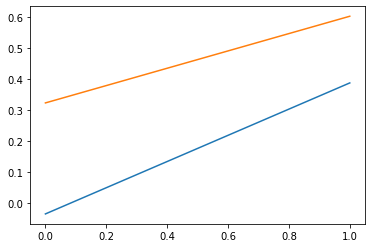

In [15]:
plt.plot(history.history['r2_score_nn'])
plt.plot(history.history['val_r2_score_nn'])
#plt.xlim(50,100)
#plt.ylim(0.0, 0.025)
print(f"max val_r2 {np.max(history.history['val_r2_score_nn'])}")

### Gjennomføre en tes 
Henter helt nye data for å gjennomføre en test på modellen.

In [16]:
filer = list(map(add_data, os.listdir('data/')))[55:60] # test 54:60
data_test = make_ready().use_stockstats(filer, indikatorer)
dataxes, datayes = prepare_data_for_test(data_test, indikatorer)

<ipython-input-9-fdaf957f94d2>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(dataxes), np.array(datayes)


In [ ]:
dataxes.shape

In [17]:
pred = []
for x in dataxes:
    pred.append(model.predict(x))

pred = np.array(pred)

<ipython-input-17-acd55e396a9b>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pred = np.array(pred)


In [18]:
for i in range(len(pred)):
    print(f"rscore for one of it {r2_score(pred[i], datayes[i])}")
    

rscore for one of it -5.194353413495586
rscore for one of it -5.167026357891758
rscore for one of it 0.18232434551410232
rscore for one of it 0.18549797784996508
rscore for one of it 0.37811454577781956


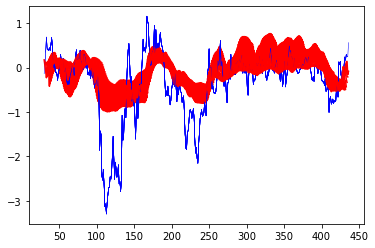

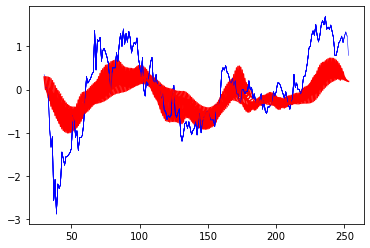

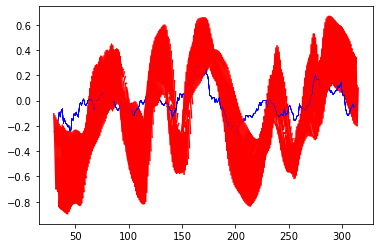

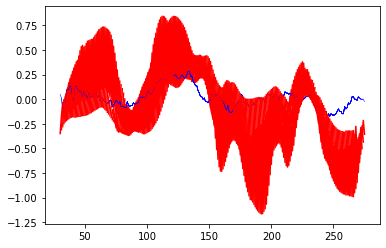

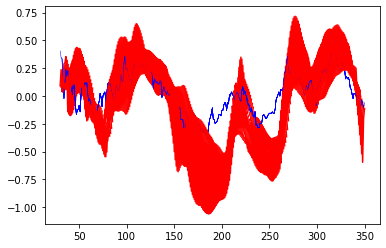

In [19]:
for i, p in enumerate(pred):
    for j, y in enumerate(p):
        
    #print(p.shape)
        plt.plot(range(30+j,40+j), datayes[i][j], c='blue', linewidth=.5)
        plt.plot(range(30+j,40+j), y, c='red')
    plt.show()

In [ ]:
plt.plot(data[0]['open'])

## Save model

In [ ]:
# Save model

model.save('models/rnn_model.h5')

In [ ]:
!dir